In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
from sklearn.preprocessing import StandardScaler

from sklearn.impute import KNNImputer
from datetime import datetime
from datetime import date
from tqdm import tqdm
import matplotlib.dates as mdates
plt.style.use('tableau-colorblind10')
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18

In [2]:
path = ""

In [3]:
# from google.colab import drive 
# drive.mount('/content/drive',force_remount=True)

# Temporal Data

### load daily confirmed cases raw data

In [4]:
daily_cases = pd.read_csv(path+'data/covid_cases/covid_confirmed_usafacts_new.csv')
daily_cases['fip'] = daily_cases['countyFIPS'].apply(lambda x: str(x).zfill(5))
daily_cases = daily_cases[1:]
print("Covid cases data shape: ", daily_cases.shape)
daily_cases.head(2)

Covid cases data shape:  (3194, 298)


,countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,fip
1,1001,Autauga County,AL,1,0,0,0,0,0,0,...,2173,2186,2197,2212,2230,2242,2267,2283,2304,01001
2,1003,Baldwin County,AL,1,0,0,0,0,0,0,...,6966,6985,6995,7061,7097,7134,7188,7226,7263,01003


In [5]:
# convert original data to format ['fip', 'County Name', 'State', 'date', 'daily_confirmed']

# get daily confirmed per row
tmp = daily_cases.copy()
cols = daily_cases.columns[4:-1]# daily cases data
tmp['daily_confirmed'] = tmp[cols].values.tolist()
# tmp['time_list'] = [list(cols)]*tmp.shape[0]

# convert list of pd.Series then stack it
tmp = (tmp
 .set_index(['fip','County Name','State'])['daily_confirmed']
 .apply(pd.Series)
 .stack()
 .reset_index()
 .rename(columns={0:'daily_confirmed'}))


tmp2 = daily_cases.copy()
cols = daily_cases.columns[4:-1]
tmp2['time_list'] = [list(cols)]*tmp2.shape[0]

tmp2 = (tmp2
 .set_index(['fip','County Name','State'])['time_list']
 .apply(pd.Series)
 .stack()
 .reset_index()
 .rename(columns={0:'old_date'}))

cases_daily = pd.merge(tmp,tmp2,on=list(tmp.columns[:4]))
del tmp,tmp2,daily_cases

# convert date format to be consistent with social distance data
def date_in_sd(case_date):
    tmp = '2020-'+case_date.split('/')[0].zfill(2)+'-'+ case_date.split('/')[1].zfill(2)
    return tmp

cases_daily['date'] = cases_daily['old_date'].apply(date_in_sd)
cases_daily = cases_daily[['fip', 'County Name', 'State', 'date', 'daily_confirmed']]

cases_daily["date"] = cases_daily["date"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())

cases_daily = cases_daily[(cases_daily["fip"] != "00000") & (cases_daily["fip"] != "00001")]
cases_daily = cases_daily[cases_daily["date"] < date(2020,11,1)]

print("Converted Covid cases data shape: ", cases_daily.shape)
cases_daily.head(2)

Converted Covid cases data shape:  (892896, 5)


,fip,County Name,State,date,daily_confirmed
0,01001,Autauga County,AL,2020-01-22,0
1,01001,Autauga County,AL,2020-01-23,0


In [6]:
# Choose targeted data by time range, we want to predict from 6/1 to 10/31, and we need previous month to train the following months.
start_date = date(2020, 5, 1) 
targeted_daily = cases_daily[cases_daily["date"] >= start_date].copy()
targeted_daily["new_cases"] = targeted_daily.groupby(by = "fip")["daily_confirmed"].diff()

print("Targeted covid data shape: ", targeted_daily.shape)
targeted_daily.head(2)

Targeted covid data shape:  (578496, 6)


,fip,County Name,State,date,daily_confirmed,new_cases
100,01001,Autauga County,AL,2020-05-01,42,NaN
101,01001,Autauga County,AL,2020-05-02,45,3.0


There are 418 counties have negative new cases


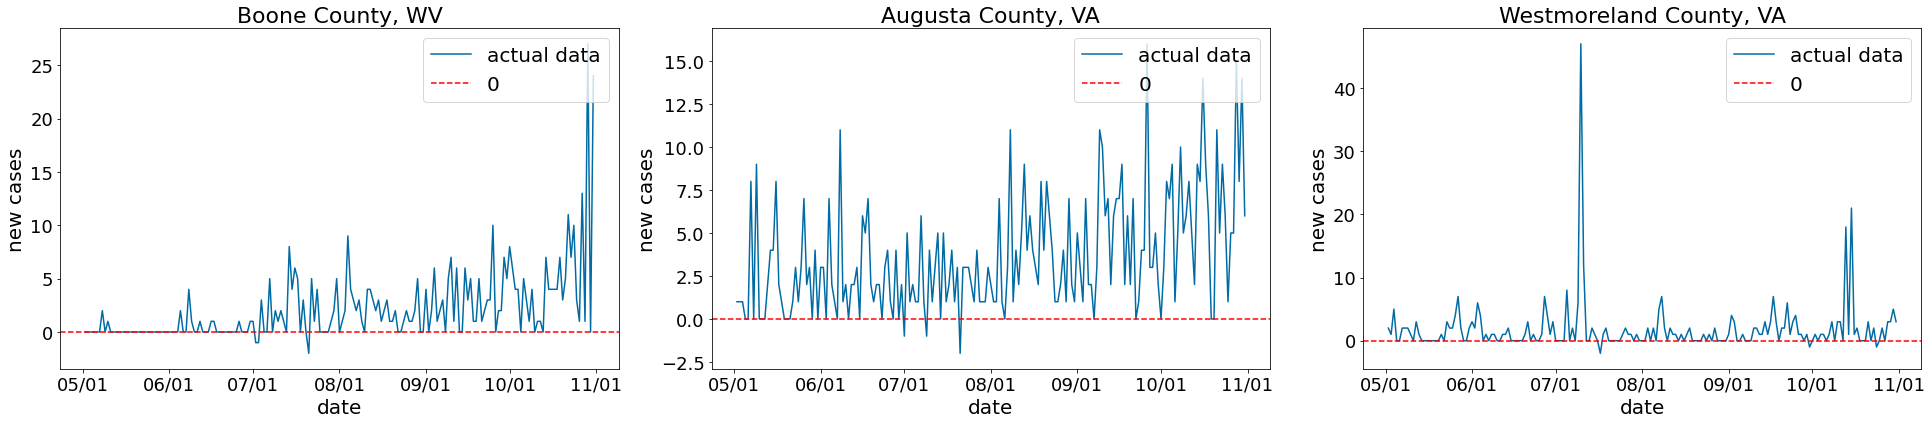

In [7]:
#We found that some counties have negative new cases
unreliable_counties = targeted_daily[targeted_daily["new_cases"]<0].groupby(by = "fip", as_index = False).count()[["fip", "new_cases"]]
print("There are %s counties have negative new cases" % len(unreliable_counties))

# Plot six of them for example
size = 3
random_counties =  unreliable_counties["fip"].values[np.argsort(unreliable_counties["new_cases"].values)[::-1][:3]] #np.random.choice(unreliable_counties, size=size)
    
fig = plt.figure(figsize = (27,6))
pos = 0
for fip in random_counties:
    cur_df = targeted_daily[targeted_daily["fip"] == fip ]
    x = cur_df["date"].values
    state_name = cur_df['State'].values[0]
    county_name = cur_df['County Name'].values[0]

    ax = fig.add_subplot(1,size,pos+1)
    formatter = mdates.DateFormatter("%m/%d")
    ax.xaxis.set_major_formatter(formatter)
#     ax.plot(x, cur_df["daily_confirmed"].values)
    ax.plot(x, cur_df["new_cases"].values, label = "actual data")
    ax.axhline(0, color = "r", linestyle = "--", label = "0")
    ax.set_title("%s, %s"%(county_name, state_name), fontsize=22)
    ax.set_xlabel("date", fontsize=20)
    ax.set_ylabel("new cases",fontsize=20)
    plt.legend(loc = "upper right", fontsize=20)

    pos += 1
plt.tight_layout()
fig.savefig(path + "graphs/unreliable_counties_new_cases.png", dpi = 200)  


In [18]:
#We decide to drop those counties with negative increases

reliable_target = targeted_daily[~targeted_daily["fip"].isin(unreliable_counties["fip"].values)]
print("Reliable targeted covid data shape: ",reliable_target.shape)
print("We have %s of counties now"%(len(reliable_target["fip"].unique())))
reliable_target.head(2)

Reliable targeted covid data shape:  (501584, 6)
We have 2726 of counties now


,fip,County Name,State,date,daily_confirmed,new_cases
100,01001,Autauga County,AL,2020-05-01,42,NaN
101,01001,Autauga County,AL,2020-05-02,45,3.0


### Import social distance data

In [19]:
sd_data_folder_path = 'data/distance_data/'
sd_data = pd.read_csv(sd_data_folder_path+"county_2020.csv")
sd_data['fip'] = sd_data['county_fips'].apply(lambda x: str(int(x)).zfill(5))

print("Social distance data shape: ", sd_data.shape)
sd_data.head(1)

Social distance data shape:  (968330, 25)


,county,county_fips,date,level,pop_not_stay_at_home,pop_stay_at_home,state_code,state_fips,trips,trips_1,...,trips_3_5,trips_500,trips_50_100,trips_5_10,only_date,weekday,pop,avg_stay_at_home_ratio,MA_7,fip
0,Autauga County,1001.0,2020-01-01,County,44621.0,10980.0,AL,1.0,148091.0,33055.0,...,20013.0,63.0,2515.0,20833.0,01/01,2,55601.0,0.197478,0.197478,01001


In [20]:
# Calculate ratio of different types of trips
sd_data["trip_ratio"] = sd_data["trips"]/sd_data["pop"]
sd_data["short_trips"] = sd_data["trips_1"] + sd_data["trips_1_3"] + sd_data["trips_3_5"] + sd_data["trips_5_10"]
sd_data["med_trips"] = sd_data["trips_10_25"] + sd_data["trips_25_50"] + sd_data["trips_25_50"] 
sd_data["long_trips"] = sd_data["trips_50_100"] + sd_data["trips_100_250"] + sd_data["trips_250_500"] + sd_data["trips_500"] 

sd_data["short_trip_ratio"] = sd_data["short_trips"]/sd_data["trips"]
sd_data["med_trip_ratio"] = sd_data["med_trips"]/sd_data["trips"]
sd_data["long_trip_ratio"] = sd_data["long_trips"]/sd_data["trips"]

sd_agg = sd_data[['date', 'fip',  'trip_ratio',"short_trip_ratio",
                    "med_trip_ratio", "long_trip_ratio",
                    "weekday","avg_stay_at_home_ratio",]].copy()

sd_agg["date"] = sd_agg["date"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())

print("Aggregated social distance data shape: ", sd_agg.shape)
sd_agg.head(2)

Aggregated social distance data shape:  (968330, 8)


,date,fip,trip_ratio,short_trip_ratio,med_trip_ratio,long_trip_ratio,weekday,avg_stay_at_home_ratio
0,2020-01-01,01001,2.663459,0.781641,0.233856,0.029468,2,0.197478
1,2020-01-01,01003,2.280829,0.754568,0.266953,0.029024,2,0.223074


### Merge cases data and social distance data

In [21]:
cases_sd = pd.merge(reliable_target,sd_agg,on = ['fip','date'], how = "left" ) # how = "outer"
print("Merged case and social distance data shape: ",cases_sd.shape)
cases_sd.head(2)

Merged case and social distance data shape:  (501584, 12)


,fip,County Name,State,date,daily_confirmed,new_cases,trip_ratio,short_trip_ratio,med_trip_ratio,long_trip_ratio,weekday,avg_stay_at_home_ratio
0,01001,Autauga County,AL,2020-05-01,42,NaN,3.382349,0.745260,0.265077,0.022844,4.0,0.181723
1,01001,Autauga County,AL,2020-05-02,45,3.0,3.212118,0.776026,0.239752,0.020611,5.0,0.192281


In [22]:
cases_sd.describe()

,daily_confirmed,new_cases,trip_ratio,short_trip_ratio,med_trip_ratio,long_trip_ratio,weekday,avg_stay_at_home_ratio
count,501584.000000,498858.000000,499310.000000,499310.000000,499310.000000,499310.000000,501216.000000,499310.000000
mean,1526.560128,14.863274,3.240078,0.710271,0.316318,0.051804,3.016304,0.213927
std,7203.654882,77.080962,0.757248,0.084318,0.104676,0.030056,1.995855,0.055472
min,0.000000,0.000000,0.064580,0.105623,0.000000,0.000000,0.000000,0.030516
25%,32.000000,0.000000,2.815443,0.668815,0.248076,0.032782,1.000000,0.177841
50%,171.000000,2.000000,3.163637,0.718657,0.306237,0.045190,3.000000,0.210708
75%,738.000000,8.000000,3.549152,0.764671,0.369305,0.062681,5.000000,0.245351
max,307618.000000,14129.000000,47.239035,1.000000,1.784163,0.779510,6.000000,0.890497


### Fill missing values in social distance data

In [23]:
fips = cases_sd.fip.unique()
print("We have %s of counties now."%len(fips))

We have 2726 of counties now.


In [24]:
filled_cases_sd = pd.DataFrame()
numerical_features = ['trip_ratio',
       'short_trip_ratio', 'med_trip_ratio', 'long_trip_ratio', 
       'avg_stay_at_home_ratio']

for fip in tqdm(fips):
    imputer = KNNImputer(n_neighbors=2)
    df = cases_sd[cases_sd["fip"] == fip].copy()
    df = df.sort_values(by=['date']).reset_index(drop = True)
    
    num = df[numerical_features]
    if imputer.fit_transform(num).shape[1] != len(numerical_features):
        continue
    num = pd.DataFrame(imputer.fit_transform(num), columns = numerical_features)
    
    df = df.drop(columns = numerical_features)
    df = pd.concat([df,num], axis = 1)
    
    filled_cases_sd = filled_cases_sd.append(df, ignore_index=True)
    
print("Filled case and social distance data shape: ",filled_cases_sd.shape)
filled_cases_sd.head(2)

100%|██████████| 2726/2726 [04:04<00:00, 11.14it/s]

Filled case and social distance data shape:  (501032, 12)


,fip,County Name,State,date,daily_confirmed,new_cases,weekday,trip_ratio,short_trip_ratio,med_trip_ratio,long_trip_ratio,avg_stay_at_home_ratio
0,01001,Autauga County,AL,2020-05-01,42,NaN,4.0,3.382349,0.745260,0.265077,0.022844,0.181723
1,01001,Autauga County,AL,2020-05-02,45,3.0,5.0,3.212118,0.776026,0.239752,0.020611,0.192281


In [25]:
# Get log new cases
filled_cases_sd["log_new_cases"] = np.log(filled_cases_sd["new_cases"] + 1)

(array([1.91078e+05, 0.00000e+00, 0.00000e+00, 5.43870e+04, 0.00000e+00,
        3.48350e+04, 0.00000e+00, 2.52940e+04, 1.96120e+04, 1.61230e+04,
        2.40410e+04, 9.27500e+03, 1.50560e+04, 1.68690e+04, 1.24170e+04,
        1.21220e+04, 9.04200e+03, 9.85200e+03, 7.29400e+03, 7.25800e+03,
        6.19900e+03, 4.99900e+03, 4.69400e+03, 3.70000e+03, 3.04000e+03,
        2.44400e+03, 2.17000e+03, 1.58400e+03, 1.33300e+03, 9.14000e+02,
        6.47000e+02, 4.95000e+02, 3.52000e+02, 2.85000e+02, 2.30000e+02,
        1.61000e+02, 1.35000e+02, 1.17000e+02, 9.00000e+01, 4.60000e+01,
        4.60000e+01, 4.50000e+01, 1.90000e+01, 4.00000e+00, 2.00000e+00,
        0.00000e+00, 0.00000e+00, 2.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([0.        , 0.19112111, 0.38224222, 0.57336333, 0.76448444,
        0.95560555, 1.14672666, 1.33784777, 1.52896888, 1.72008999,
        1.9112111 , 2.1023322 , 2.29345331, 2.48457442, 2.67569553,
        2.86681664, 3.05793775, 3.24905886, 3.44017997, 3.631301

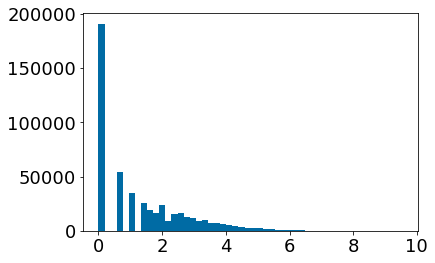

In [26]:
# Plot 
plt.hist(filled_cases_sd["log_new_cases"].values, bins = 50)

<AxesSubplot:>

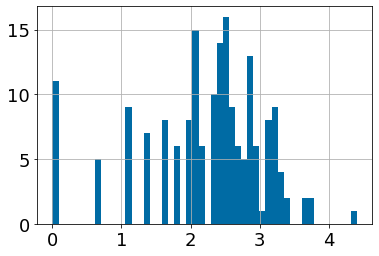

In [27]:
filled_cases_sd[filled_cases_sd["fip"] == fips[0]]["log_new_cases"].hist(bins = 50)

### Load data for neightbor counties

In [28]:
spacial_data = pd.read_csv(path+"data/spacial_data/neighborcounties.csv")

In [29]:
spacial_data["orgfips"] = spacial_data["orgfips"].apply(lambda x: str(int(x)).zfill(5))
spacial_data["adjfips"] = spacial_data["adjfips"].apply(lambda x: str(int(x)).zfill(5))

print("Neighbor counties data shape: ", spacial_data.shape)
spacial_data.head(2)

Neighbor counties data shape:  (18220, 3)


,orgfips,adjfips,instate
0,01001,01021,1
1,01001,01047,1


In [30]:
dates = filled_cases_sd["date"].unique()

In [31]:
spacial_df = pd.DataFrame()

for date_ in tqdm(dates):
    case_temp = filled_cases_sd[filled_cases_sd["date"] == date_]
    spacial_temp = spacial_data.merge(case_temp, left_on = "adjfips",
                                      right_on = "fip", how = "inner")

    spacial_temp_group = spacial_temp.groupby(by = "orgfips", as_index = False).mean()[["orgfips","daily_confirmed"]]
    spacial_temp_group.columns = ["orgfips", "mean_neighbor_daily_confirmed"]
    spacial_temp_group["date"] = date_
    spacial_df = spacial_df.append(spacial_temp_group,ignore_index = True)

spacial_df["mean_neightbor_new_cases"] = spacial_df.groupby(by = "orgfips")["mean_neighbor_daily_confirmed"].diff()

    
print("Neighbor counties with daily cases: ", spacial_df.shape)
spacial_df.head(2)

100%|██████████| 184/184 [00:16<00:00, 10.91it/s]


Neighbor counties with daily cases:  (575736, 4)


,orgfips,mean_neighbor_daily_confirmed,date,mean_neightbor_new_cases
0,01001,60.666667,2020-05-01,NaN
1,01003,290.333333,2020-05-01,NaN


In [32]:
spacial_not_na = spacial_df.dropna()
spacial_not_na.groupby("orgfips").count()["date"].unique()

array([183])

In [33]:
spacial_not_na["neighbor_log_new_cases"] =  np.log(spacial_not_na["mean_neightbor_new_cases"] + 1)
print("Neighbor counties without nans: ", spacial_not_na.shape)
spacial_not_na.head(2)

Neighbor counties without nans:  (572607, 5)


/Users/mac/opt/anaconda3/envs/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,orgfips,mean_neighbor_daily_confirmed,date,mean_neightbor_new_cases,neighbor_log_new_cases
3129,01001,65.333333,2020-05-02,4.666667,1.734601
3130,01003,304.666667,2020-05-02,14.333333,2.730029


In [34]:
temporal = filled_cases_sd.merge(spacial_not_na, left_on = ["fip","date"], right_on = ["orgfips","date"], how = "inner")

# county_state_fip.to_csv("/content/drive/MyDrive/209 Project/data/county_state_fip.csv", index = False)


In [35]:
temporal = temporal.drop(columns = ['orgfips',"weekday"]) # 'County Name', 'State'
temporal = temporal.dropna()
temporal.shape

(496479, 15)

In [37]:
fips = temporal["fip"].unique()
print("We have %s counties now."%(len(fips)))

We have 2713 counties now.


In [38]:
temporal.to_csv(path+"data/temporal.csv", index = False)
# temporal.to_csv("/content/drive/MyDrive/209 Project/data/temporal.csv", index = False)

# Static Data

### Load data for hospital bed

### import social and economic data for each country

In [39]:
social_eco = pd.read_csv(path+'data/social_economics/main_all_counties.csv')
social_eco['fip'] = social_eco['FIPS'].apply(lambda x: str(int(x)).zfill(5))
social_eco.head()

,FIPS,state,county_name,NCHS_urbanization,total_population,num_beds,confirmed,deaths,beds_per_1000,confirmed_per_1000,...,deaths_quartile,2018_rank_in_state_per_capita_income,2016_per_capita_income,2017_per_capita_income,2017_per_capita_income_percent_change,2018_per_capita_income_percent_change,rank_in_state_2018_per_capita_income_percent_change,confirmed_per_100000,deaths_per_100000,fip
0,2020,Alaska,Anchorage,Medium metro,296112,753.0,3297,25,2.542957,11.134301,...,1,10,62172,63173,1.6,5.3,12,1113.43,8.44,02020
1,2100,Alaska,Haines,Non-core,2518,57.0,4,0,22.637014,1.588562,...,0,9,57423,62478,8.8,7.3,3,158.86,0.00,02100
2,2122,Alaska,Kenai Peninsula,Non-core,58220,109.0,422,2,1.872209,7.248368,...,0,21,49544,49697,0.3,4.7,15,724.84,3.44,02122
3,2090,Alaska,Fairbanks North Star,Small metro,99653,212.0,755,9,2.127382,7.576290,...,1,19,52803,53974,2.2,4.9,14,757.63,9.03,02090
4,2170,Alaska,Matanuska-Susitna,Medium metro,103464,109.0,511,2,1.053507,4.938916,...,0,26,44520,44043,-1.1,4.2,18,493.89,1.93,02170


In [40]:
useful_features = ["over_65_percent","no_diploma_percent","no_insurance_percent",
                   "unemployed_percent","poverty_percent", 'over_65_percent','beds_per_1000']
social_eco_selected = social_eco[useful_features+["fip"]]
print("Selected social-economic features shape:", social_eco_selected.shape)
social_eco_selected.head(2)

Selected social-economic features shape: (3114, 8)


,over_65_percent,no_diploma_percent,no_insurance_percent,unemployed_percent,poverty_percent,over_65_percent,beds_per_1000,fip
0,10.0,7.4656,16.7,5.8,7.2,10.0,2.542957,02020
1,22.1,4.2644,24.5,7.4,10.3,22.1,22.637014,02100


In [41]:
social_eco_clean = social_eco_selected[social_eco_selected["fip"].isin(fips)]
social_eco_clean = social_eco_clean.dropna()
print("Selected social-economic features of specific counties shape:",social_eco_clean.shape)
social_eco_clean.head(2)

Selected social-economic features of specific counties shape: (2682, 8)


,over_65_percent,no_diploma_percent,no_insurance_percent,unemployed_percent,poverty_percent,over_65_percent,beds_per_1000,fip
0,10.0,7.4656,16.7,5.8,7.2,10.0,2.542957,02020
1,22.1,4.2644,24.5,7.4,10.3,22.1,22.637014,02100


In [42]:
static_scalars = {}
static = social_eco_clean.copy()
for col in useful_features:
    scaler = StandardScaler().fit(static[[col]])
    static_scalars[col] = scaler
    static[col] = scaler.transform(static[[col]])
print(static.shape)
static.head(2)

(2682, 8)


,over_65_percent,no_diploma_percent,no_insurance_percent,unemployed_percent,poverty_percent,over_65_percent,beds_per_1000,fip
0,-1.964415,-1.107921,0.445628,0.926222,-1.388236,-1.964415,0.296673,02020
1,0.606299,-1.581386,1.937229,1.915372,-0.890546,0.606299,5.594353,02100


In [43]:
temp_static = temporal.merge(static, on = "fip", how = "inner")
fips = temp_static["fip"].unique()
print("We have %s counties now."%len(fips))
temp_static.shape

We have 2682 counties now.


(490806, 22)

In [44]:
county_state_fip = temporal[temporal["fip"].isin(fips)][["fip","County Name", "State"]].drop_duplicates().reset_index(drop = True)
print("Temporal info with neighbor counties", county_state_fip.shape)
county_state_fip.to_csv(path+"data/county_state_fip.csv", index = False)


Temporal info with neighbor counties (2682, 3)


In [ ]:
static.to_csv(path+"data/static.csv", index = False)
temp_static.to_csv(path+"data/temp_static.csv", index = False)
